In [1]:
from IPython.display import FileLink

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate

import os
import imageio.v2 as imageio  

In [3]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [4]:
data_matrices = {}
for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix

In [5]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]

In [6]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T
for i in range(n):
    data_matrices[f'd{i}'] = np.reshape(data_matrices[f'd{i}'],27*73)

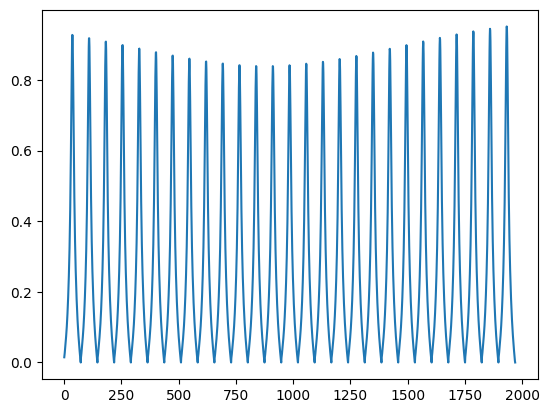

In [32]:
plt.plot(np.arange(0,73*27,1), data_matrices['d10'])

In [7]:
n_train = int(n*0.9*0.9)
n_val = int(n*0.9*0.1)
n_test = n-n_train-n_val

train_data = []
val_data = []
test_data = []

In [8]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n_train+n_val,1):
    val_data.append(data_matrices[f'd{i}'])
    
for i in range(n_train+n_val,n,1):
    test_data.append(data_matrices[f'd{i}'])

In [35]:
np.shape(test_data)

(6, 1971)

In [9]:
train_data = np.array(train_data).reshape(n_train,27*73)
val_data = np.array(val_data).reshape(n_val,27*73)
test_data = np.array(test_data).reshape(n_test, 27*73)

In [37]:
train2 = train_data[0,:].reshape(27,73)

image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
  plt.plot(RV[:], train2[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('diff CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('prova_train.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

FileLink('prova_train.gif')

C:\Users\jenni\starsim\new_data_1period\1CCF\prova_train.gif

In [51]:
latent_dims = np.arange(1,21,1)
lossesvecval = []


for i in range(len(latent_dims)):
    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dims[i]
            self.encoder = tf.keras.Sequential([
            layers.Dense(27*73, activation='linear'),
              layers.Dense(200, activation='relu'),
              layers.Dense(20, activation='relu'),
              layers.Dense(latent_dims[i], activation='relu'),
              ])
            self.decoder = tf.keras.Sequential([
                layers.Dense(20, activation='relu'),
                layers.Dense(200, activation='relu'),
                layers.Dense(27*73, activation='linear'),
              ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded


    autoencoder = Autoencoder(latent_dim=latent_dims[i])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

    initial_learning_rate = 0.1
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='mse')

    optimizer = tf.keras.optimizers.Adam()


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = autoencoder.fit(train_data, train_data,
                              epochs=50,
                              shuffle=True,
                              batch_size=64,
                              validation_data=(val_data, val_data),
                               callbacks=[reduce_lr, early_stopping])

    last_epoch_loss2 = history.history['val_loss'][-1]
    lossesvecval.append(last_epoch_loss2)


Epoch 1/50
13/13 [==============================] - 3s 81ms/step - loss: 0.0392 - val_loss: 0.0114 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 1s 41ms/step - loss: 0.0082 - val_loss: 0.0020 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0011 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 1s 42ms/step - loss: 5.9540e-04 - val_loss: 4.0467e-04 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 38ms/step - loss: 3.0064e-04 - val_loss: 2.1123e-04 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 38ms/step - loss: 2.0159e-04 - val_loss: 1.5419e-04 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 0s 38ms/step - loss: 1.7352e-04 - val_loss: 1.4503e-04 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 36ms/step - loss: 1.6609e-04 - val_loss: 1.4289e-04 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 0s 36ms/step

Epoch 18/50
13/13 [==============================] - 0s 37ms/step - loss: 1.6241e-04 - val_loss: 1.4079e-04 - lr: 1.0000e-03
Epoch 19/50
13/13 [==============================] - 0s 35ms/step - loss: 1.6240e-04 - val_loss: 1.4107e-04 - lr: 1.0000e-03
Epoch 20/50
13/13 [==============================] - 0s 34ms/step - loss: 1.6237e-04 - val_loss: 1.4094e-04 - lr: 1.0000e-03
Epoch 21/50
13/13 [==============================] - 0s 36ms/step - loss: 1.6237e-04 - val_loss: 1.4093e-04 - lr: 1.0000e-03
Epoch 22/50
13/13 [==============================] - 0s 38ms/step - loss: 1.6237e-04 - val_loss: 1.4093e-04 - lr: 1.0000e-03
Epoch 23/50
13/13 [==============================] - 1s 41ms/step - loss: 1.6235e-04 - val_loss: 1.4090e-04 - lr: 1.0000e-04
Epoch 1/50
13/13 [==============================] - 3s 83ms/step - loss: 290633.3750 - val_loss: 0.4063 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 1s 42ms/step - loss: 0.2124 - val_loss: 0.0416 - lr: 0.1000
Epoch 3/50
13/13 [===

Epoch 7/50
13/13 [==============================] - 0s 38ms/step - loss: 1.7731e-04 - val_loss: 1.4713e-04 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 38ms/step - loss: 1.7775e-04 - val_loss: 1.5220e-04 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 1s 41ms/step - loss: 1.7447e-04 - val_loss: 1.4257e-04 - lr: 0.1000
Epoch 10/50
13/13 [==============================] - 0s 39ms/step - loss: 1.7928e-04 - val_loss: 1.5027e-04 - lr: 0.1000
Epoch 11/50
13/13 [==============================] - 0s 38ms/step - loss: 1.6898e-04 - val_loss: 1.4596e-04 - lr: 0.0100
Epoch 12/50
13/13 [==============================] - 0s 37ms/step - loss: 1.6546e-04 - val_loss: 1.4366e-04 - lr: 0.0100
Epoch 13/50
13/13 [==============================] - 0s 39ms/step - loss: 1.6638e-04 - val_loss: 1.4145e-04 - lr: 0.0100
Epoch 14/50
13/13 [==============================] - 0s 37ms/step - loss: 1.6354e-04 - val_loss: 1.4354e-04 - lr: 0.0100
Epoch 15/50
13/13 [================

13/13 [==============================] - 1s 42ms/step - loss: 1.6614e-04 - val_loss: 1.4150e-04 - lr: 0.1000
Epoch 11/50
13/13 [==============================] - 1s 40ms/step - loss: 1.8604e-04 - val_loss: 1.6185e-04 - lr: 0.1000
Epoch 12/50
13/13 [==============================] - 0s 39ms/step - loss: 2.2021e-04 - val_loss: 2.5150e-04 - lr: 0.1000
Epoch 13/50
13/13 [==============================] - 0s 39ms/step - loss: 4.9756e-04 - val_loss: 4.7948e-04 - lr: 0.1000
Epoch 14/50
13/13 [==============================] - 1s 40ms/step - loss: 2.7493e-04 - val_loss: 1.4194e-04 - lr: 0.0100
Epoch 15/50
13/13 [==============================] - 0s 39ms/step - loss: 1.8481e-04 - val_loss: 1.5793e-04 - lr: 0.0100
Epoch 16/50
13/13 [==============================] - 1s 39ms/step - loss: 1.6909e-04 - val_loss: 1.4404e-04 - lr: 0.0100
Epoch 17/50
13/13 [==============================] - 1s 39ms/step - loss: 1.6590e-04 - val_loss: 1.4152e-04 - lr: 0.0100
Epoch 18/50
13/13 [=========================

Epoch 24/50
13/13 [==============================] - 1s 39ms/step - loss: 0.0120 - val_loss: 0.0122 - lr: 0.1000
Epoch 25/50
13/13 [==============================] - 1s 40ms/step - loss: 0.0119 - val_loss: 0.0120 - lr: 0.1000
Epoch 26/50
13/13 [==============================] - 1s 42ms/step - loss: 0.0122 - val_loss: 0.0118 - lr: 0.1000
Epoch 27/50
13/13 [==============================] - 0s 37ms/step - loss: 0.0126 - val_loss: 0.0119 - lr: 0.1000
Epoch 28/50
13/13 [==============================] - 1s 40ms/step - loss: 0.0116 - val_loss: 0.0115 - lr: 0.1000
Epoch 29/50
13/13 [==============================] - 1s 40ms/step - loss: 0.0114 - val_loss: 0.0113 - lr: 0.1000
Epoch 30/50
13/13 [==============================] - 1s 40ms/step - loss: 0.0113 - val_loss: 0.0112 - lr: 0.1000
Epoch 31/50
13/13 [==============================] - 0s 39ms/step - loss: 0.0112 - val_loss: 0.0112 - lr: 0.1000
Epoch 32/50
13/13 [==============================] - 0s 39ms/step - loss: 0.0114 - val_loss: 0.0

Text(0, 0.5, 'Val loss')

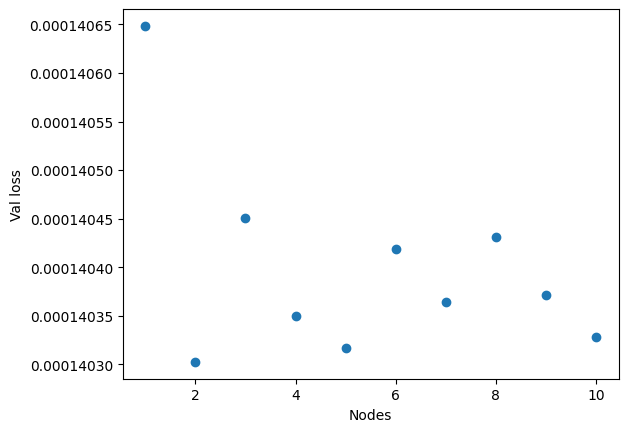

In [194]:
plt.scatter(np.arange(1,11,1),lossesvecval)
plt.xlabel('Nodes')
plt.ylabel('Val loss')

In [193]:
lossesvecval

[0.00014064839342609048,
 0.00014030252350494266,
 0.00014045109855942428,
 0.0001403496426064521,
 0.00014031730825081468,
 0.00014041844406165183,
 0.00014036434004083276,
 0.0001404312497470528,
 0.00014037142229724676,
 0.00014032816397957504]

In [198]:
latent_dim = 2
lossesvecval = []
activations = ['relu', 'linear', 'sigmoid']
nodes1 = [700,500,200]
nodes2 = [100, 50, 15]


for k in range(len(activations)):
    for j in range(len(nodes1)):
        for i in range(len(nodes2)):
            class Autoencoder(Model):
              def __init__(self, latent_dim):
                super(Autoencoder, self).__init__()
                self.latent_dim = latent_dim
                self.encoder = tf.keras.Sequential([
                layers.Dense(27*73, activation='linear'),
                      layers.Dense(nodes1[j], activation=activations[k]),
                      layers.Dense(nodes2[i], activation='relu'),
                      layers.Dense(latent_dim, activation='relu'),
                      ])
                self.decoder = tf.keras.Sequential([
                        layers.Dense(nodes2[i], activation='relu'),
                        layers.Dense(nodes1[j], activation=activations[k]),
                        layers.Dense(27*73, activation='linear'),
                      ])

              def call(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded


            autoencoder = Autoencoder(latent_dim)

            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

            initial_learning_rate = 0.1
            autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                          loss='mse')

            optimizer = tf.keras.optimizers.Adam()


            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


            history = autoencoder.fit(train_data, train_data,
                                      epochs=50,
                                      shuffle=True,
                                      batch_size=64,
                                      validation_data=(val_data, val_data),
                                       callbacks=[reduce_lr, early_stopping])
        
            last_epoch_loss2 = history.history['val_loss'][-1]
            lossesvecval.append(last_epoch_loss2)


Epoch 1/50
13/13 [==============================] - 1s 43ms/step - loss: 3277373.2500 - val_loss: 13.3872 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 28ms/step - loss: 5.2542 - val_loss: 0.0862 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6520 - val_loss: 0.0868 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 28ms/step - loss: 0.5022 - val_loss: 0.4967 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1675 - val_loss: 0.1318 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0511 - val_loss: 0.0338 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0148 - val_loss: 0.0099 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0030 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.003

Epoch 13/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6262e-04 - val_loss: 1.4042e-04 - lr: 0.0100
Epoch 14/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6313e-04 - val_loss: 1.4035e-04 - lr: 0.0100
Epoch 15/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6267e-04 - val_loss: 1.4052e-04 - lr: 1.0000e-03
Epoch 16/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6242e-04 - val_loss: 1.4118e-04 - lr: 1.0000e-03
Epoch 17/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6244e-04 - val_loss: 1.4098e-04 - lr: 1.0000e-03
Epoch 18/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6241e-04 - val_loss: 1.4088e-04 - lr: 1.0000e-03
Epoch 19/50
13/13 [==============================] - 0s 29ms/step - loss: 1.6243e-04 - val_loss: 1.4066e-04 - lr: 1.0000e-03
Epoch 20/50
13/13 [==============================] - 1s 41ms/step - loss: 1.6237e-04 - val_loss: 1.4068e-04 - lr: 1.0000e-04
Epoch 1/

13/13 [==============================] - 0s 27ms/step - loss: 1.6260e-04 - val_loss: 1.4125e-04 - lr: 1.0000e-03
Epoch 21/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6264e-04 - val_loss: 1.4056e-04 - lr: 1.0000e-03
Epoch 22/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6248e-04 - val_loss: 1.4095e-04 - lr: 1.0000e-03
Epoch 23/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6257e-04 - val_loss: 1.4087e-04 - lr: 1.0000e-03
Epoch 24/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6236e-04 - val_loss: 1.4092e-04 - lr: 1.0000e-04
Epoch 25/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6237e-04 - val_loss: 1.4093e-04 - lr: 1.0000e-04
Epoch 26/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6237e-04 - val_loss: 1.4091e-04 - lr: 1.0000e-04
Epoch 27/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6242e-04 - val_loss: 1.4089e-04 - lr: 1.0000e-04
Epoch 28/50


13/13 [==============================] - 0s 33ms/step - loss: 68.4534 - val_loss: 64.6784 - lr: 0.1000
Epoch 26/50
13/13 [==============================] - 0s 33ms/step - loss: 61.7848 - val_loss: 58.3719 - lr: 0.1000
Epoch 27/50
13/13 [==============================] - 0s 31ms/step - loss: 55.7542 - val_loss: 52.6672 - lr: 0.1000
Epoch 28/50
13/13 [==============================] - 0s 32ms/step - loss: 50.2983 - val_loss: 47.5053 - lr: 0.1000
Epoch 29/50
13/13 [==============================] - 0s 32ms/step - loss: 45.3611 - val_loss: 42.8337 - lr: 0.1000
Epoch 30/50
13/13 [==============================] - 0s 32ms/step - loss: 40.8927 - val_loss: 38.6054 - lr: 0.1000
Epoch 31/50
13/13 [==============================] - 0s 32ms/step - loss: 36.8484 - val_loss: 34.7787 - lr: 0.1000
Epoch 32/50
13/13 [==============================] - 0s 32ms/step - loss: 33.1884 - val_loss: 31.3159 - lr: 0.1000
Epoch 33/50
13/13 [==============================] - 0s 32ms/step - loss: 29.8768 - val_loss

Epoch 23/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6236e-04 - val_loss: 1.4075e-04 - lr: 1.0000e-03
Epoch 24/50
13/13 [==============================] - 0s 27ms/step - loss: 1.6236e-04 - val_loss: 1.4076e-04 - lr: 1.0000e-03
Epoch 1/50
13/13 [==============================] - 2s 40ms/step - loss: 341313.6562 - val_loss: 4.2715 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 25ms/step - loss: 35.8110 - val_loss: 42.6497 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 26ms/step - loss: 19.6351 - val_loss: 15.5395 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 27ms/step - loss: 11.9299 - val_loss: 10.0554 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 28ms/step - loss: 9.2216 - val_loss: 8.7622 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 29ms/step - loss: 8.1625 - val_loss: 7.8535 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 0s 28ms/step - 

Epoch 26/50
13/13 [==============================] - 0s 23ms/step - loss: 1.6237e-04 - val_loss: 1.4071e-04 - lr: 1.0000e-04
Epoch 27/50
13/13 [==============================] - 0s 23ms/step - loss: 1.6235e-04 - val_loss: 1.4073e-04 - lr: 1.0000e-04
Epoch 28/50
13/13 [==============================] - 0s 23ms/step - loss: 1.6235e-04 - val_loss: 1.4073e-04 - lr: 1.0000e-05
Epoch 29/50
13/13 [==============================] - 0s 23ms/step - loss: 1.6235e-04 - val_loss: 1.4073e-04 - lr: 1.0000e-05
Epoch 1/50
13/13 [==============================] - 1s 35ms/step - loss: 0.5306 - val_loss: 0.3869 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 22ms/step - loss: 0.1287 - val_loss: 0.0149 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0225 - val_loss: 0.0182 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 26ms/step - loss: 0.0066 - val_loss: 0.0011 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 

Epoch 32/50
13/13 [==============================] - 0s 32ms/step - loss: 1.6234e-04 - val_loss: 1.4086e-04 - lr: 1.0000e-04
Epoch 33/50
13/13 [==============================] - 0s 33ms/step - loss: 1.6234e-04 - val_loss: 1.4086e-04 - lr: 1.0000e-04
Epoch 34/50
13/13 [==============================] - 0s 33ms/step - loss: 1.6234e-04 - val_loss: 1.4086e-04 - lr: 1.0000e-04
Epoch 1/50
13/13 [==============================] - 2s 45ms/step - loss: 238.5053 - val_loss: 66.1264 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 30ms/step - loss: 28.7459 - val_loss: 0.7985 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 30ms/step - loss: 6.2133 - val_loss: 0.2200 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 32ms/step - loss: 1.4883 - val_loss: 0.1232 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 36ms/step - loss: 0.3535 - val_loss: 0.0575 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 32ms/s

Epoch 16/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6417e-04 - val_loss: 1.4191e-04 - lr: 0.0100
Epoch 17/50
13/13 [==============================] - 0s 29ms/step - loss: 1.6319e-04 - val_loss: 1.4081e-04 - lr: 0.0100
Epoch 18/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6305e-04 - val_loss: 1.4235e-04 - lr: 0.0100
Epoch 19/50
13/13 [==============================] - 0s 29ms/step - loss: 1.6352e-04 - val_loss: 1.4221e-04 - lr: 0.0100
Epoch 20/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6306e-04 - val_loss: 1.4177e-04 - lr: 1.0000e-03
Epoch 21/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6251e-04 - val_loss: 1.4089e-04 - lr: 1.0000e-03
Epoch 22/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6238e-04 - val_loss: 1.4078e-04 - lr: 1.0000e-03
Epoch 23/50
13/13 [==============================] - 0s 28ms/step - loss: 1.6244e-04 - val_loss: 1.4081e-04 - lr: 1.0000e-03
Epoch 24/50
13/1

13/13 [==============================] - 0s 30ms/step - loss: 1.6234e-04 - val_loss: 1.4080e-04 - lr: 1.0000e-04
Epoch 26/50
13/13 [==============================] - 0s 30ms/step - loss: 1.6235e-04 - val_loss: 1.4080e-04 - lr: 1.0000e-04


In [212]:
print(np.min(lossesvecval), np.argmin(lossesvecval))

0.00014024526171851903 12


Text(0, 0.5, 'Val loss')

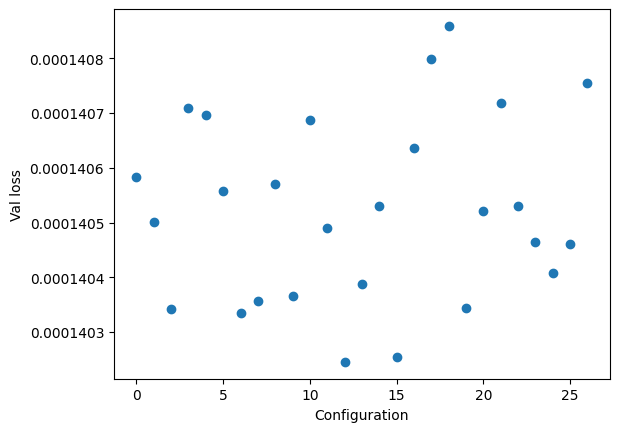

In [211]:
plt.scatter(np.arange(0,27,1),lossesvecval)
plt.xlabel('Configuration')
plt.ylabel('Val loss')

In [213]:
lossesvecval

[0.000140582793392241,
 0.00014050070603843778,
 0.00014034273044671863,
 0.0001407094532623887,
 0.00014069593453314155,
 0.00014055844803806394,
 0.00014033449406269938,
 0.00014035693311598152,
 0.0001405699149472639,
 0.00014036562060937285,
 0.00014068714517634362,
 0.00014048919547349215,
 0.00014024526171851903,
 0.0001403884671162814,
 0.00014052947517484426,
 0.0001402535563101992,
 0.00014063689741306007,
 0.00014079862739890814,
 0.00014085936709307134,
 0.00014034360356163234,
 0.00014052183541934937,
 0.00014071828627493232,
 0.00014052947517484426,
 0.00014046407886780798,
 0.00014040818496141583,
 0.0001404607464792207,
 0.00014075552462600172]

Final architecture: linear, 500, 15

In [10]:
latent_dim = 2
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
        layers.Dense(27*73, activation='linear'),
          layers.Dense(500, activation='linear'),
          layers.Dense(15, activation='relu'),
          layers.Dense(latent_dim, activation='relu'),
          ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(15, activation='relu'),
            layers.Dense(500, activation='relu'),
            layers.Dense(27*73, activation='linear'),
          ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim=latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

initial_learning_rate = 0.1
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          shuffle=True,
                          batch_size=64,
                          validation_data=(val_data, val_data),
                           callbacks=[reduce_lr, early_stopping])



Epoch 1/50
13/13 [==============================] - 4s 102ms/step - loss: 18830376.0000 - val_loss: 5.5920 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 1s 50ms/step - loss: 3.4857 - val_loss: 2.4660 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 1s 50ms/step - loss: 0.9049 - val_loss: 0.0724 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 1s 50ms/step - loss: 0.2125 - val_loss: 0.2089 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 1s 48ms/step - loss: 0.0730 - val_loss: 0.0171 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 1s 50ms/step - loss: 0.0188 - val_loss: 0.0012 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 1s 49ms/step - loss: 0.0049 - val_loss: 2.1397e-04 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 1s 46ms/step - loss: 0.0013 - val_loss: 2.3705e-04 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 1s 47ms/step - loss: 4.5234e-04 - va

In [218]:
test_pred = np.reshape(test_data[0,:], (1,27*73))
predictions = autoencoder.predict(test_pred)
predictions = np.reshape(predictions, (27*73))

1/1 [==============================] - 0s 58ms/step


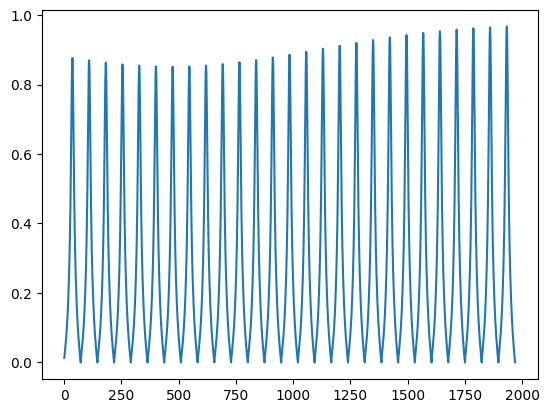

In [73]:
plt.plot(np.arange(0,73*27,1), predictions)

In [219]:
predictions = np.reshape(predictions, (27,73))

In [220]:
jet=plt.get_cmap('rainbow')
colors=iter(jet(np.linspace(0,0.5,27)))
colors1=iter(jet(np.linspace(0.5,1,27)))
test2 = test_data[0,:].reshape(27,73)


image_filenames2 = []
for j in range(27):
  plt.plot(RV[:], predictions[j,:], color=next(colors))  
  plt.plot(RV[:], test2[j,:], color='red')  
  plt.xlabel('RV')
  plt.ylim((0,1))
  plt.ylabel('CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames2.append(filename)
with imageio.get_writer('plotsTest2_pred.gif', mode='I') as writer:
  for filename in image_filenames2:
    image = imageio.imread(filename)
    writer.append_data(image)

for filename in image_filenames2:
   os.remove(filename)

FileLink('plotsTest2_pred.gif')


C:\Users\jenni\starsim\new_data_1period\1CCF\plotsTest2_pred.gif